In [ ]:
!pip install timm medmnist scikit-learn matplotlib seaborn
!pip install  pandas  pillow tqdm



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 6.3 MB/s eta 0:00:00


In [ ]:
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from medmnist import PneumoniaMNIST
from medmnist import INFO
from torchvision import transforms


In [ ]:
info = INFO["pneumoniamnist"]
DataClass = PneumoniaMNIST

train_data = DataClass(split="train", download=True)
val_data   = DataClass(split="val", download=True)
test_data  = DataClass(split="test", download=True)


100%|██████████| 4.17M/4.17M [00:04<00:00, 989kB/s] 


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Normalize([0.5]*3,[0.5]*3)
])

train_data.transform = transform
val_data.transform   = transform
test_data.transform  = transform


In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)


In [ ]:
def get_model(name):
    return timm.create_model(name, pretrained=True, num_classes=2)


In [ ]:
def train_model(model_name, epochs=10):
    device = "cuda"
    model = get_model(model_name).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):

        model.train()
        correct,total,loss_sum = 0,0,0
        for x,y in train_loader:
            x,y = x.to(device), y.squeeze().long().to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out,y)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            correct += (out.argmax(1)==y).sum().item()
            total += y.size(0)

        train_losses.append(loss_sum/len(train_loader))
        train_accs.append(correct/total)


        model.eval()
        correct,total,loss_sum = 0,0,0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.squeeze().long().to(device)
                out = model(x)
                loss = criterion(out,y)

                loss_sum += loss.item()
                correct += (out.argmax(1)==y).sum().item()
                total += y.size(0)

        val_losses.append(loss_sum/len(val_loader))
        val_accs.append(correct/total)
        print(model_name,epoch+1,":","Train Acc",train_acs[-1],"Val Acc",val_accs[-1])




    plt.plot(train_losses,label="Train")
    plt.plot(val_losses,label="Val")

    plt.legend()
    plt.show()

    plt.plot(train_accs,label="Train")
    plt.plot(val_accs,label="Val")

    plt.legend()
    plt.show()


    model.eval()
    y_true,y_pred = [],[]
    with torch.no_grad():
        for x,y in test_loader:
            x = x.to(device)
            out = model(x)
            y_pred.extend(out.argmax(1).cpu().numpy())
            y_true.extend(y.squeeze().numpy())

    print(classification_report(y_true,y_pred,target_names=["Normal","Pneumonia"]))

    cm = confusion_matrix(y_true,y_pred)
    sns.heatmap(cm,annot=True,fmt="d")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    acc = accuracy_score(y_true,y_pred)
    prec,rec,f1,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")

    print("Accuracy:",acc)
    print("Precision:",prec)
    print("Recall:",rec)
    print("F1:",f1)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

convnextv2_tiny | Epoch 1: Train Acc=0.907, Val Acc=0.975
convnextv2_tiny | Epoch 2: Train Acc=0.967, Val Acc=0.968
convnextv2_tiny | Epoch 3: Train Acc=0.972, Val Acc=0.966
convnextv2_tiny | Epoch 4: Train Acc=0.975, Val Acc=0.971
convnextv2_tiny | Epoch 5: Train Acc=0.980, Val Acc=0.966
convnextv2_tiny | Epoch 6: Train Acc=0.987, Val Acc=0.943
convnextv2_tiny | Epoch 7: Train Acc=0.981, Val Acc=0.954
convnextv2_tiny | Epoch 8: Train Acc=0.983, Val Acc=0.975
convnextv2_tiny | Epoch 9: Train Acc=0.991, Val Acc=0.971
convnextv2_tiny | Epoch 10: Train Acc=0.994, Val Acc=0.968


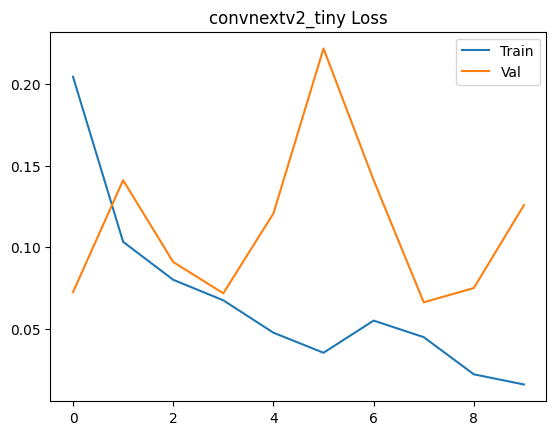

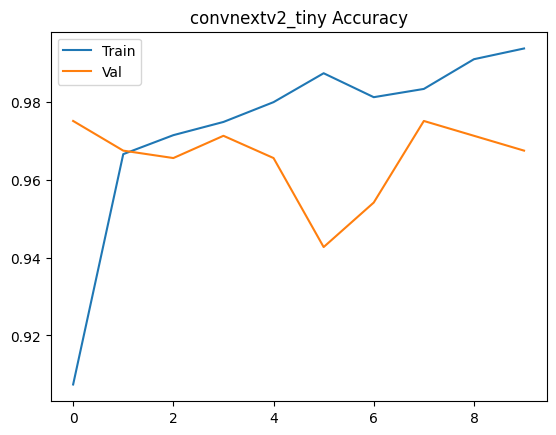

              precision    recall  f1-score   support

      Normal       0.98      0.77      0.86       234
   Pneumonia       0.88      0.99      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.92      0.91      0.91       624



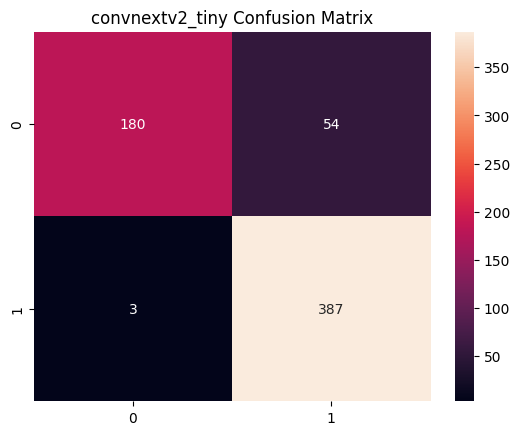

Accuracy: 0.9086538461538461
Precision: 0.9173218467714955
Recall: 0.9086538461538461
F1: 0.9058709710931615


In [ ]:
train_model("convnextv2_tiny")


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

efficientnet_b0 | Epoch 1: Train Acc=0.913, Val Acc=0.948
efficientnet_b0 | Epoch 2: Train Acc=0.980, Val Acc=0.947
efficientnet_b0 | Epoch 3: Train Acc=0.996, Val Acc=0.958
efficientnet_b0 | Epoch 4: Train Acc=0.999, Val Acc=0.962
efficientnet_b0 | Epoch 5: Train Acc=0.998, Val Acc=0.956
efficientnet_b0 | Epoch 6: Train Acc=0.996, Val Acc=0.960
efficientnet_b0 | Epoch 7: Train Acc=0.996, Val Acc=0.950
efficientnet_b0 | Epoch 8: Train Acc=0.989, Val Acc=0.966
efficientnet_b0 | Epoch 9: Train Acc=0.993, Val Acc=0.962
efficientnet_b0 | Epoch 10: Train Acc=0.995, Val Acc=0.969


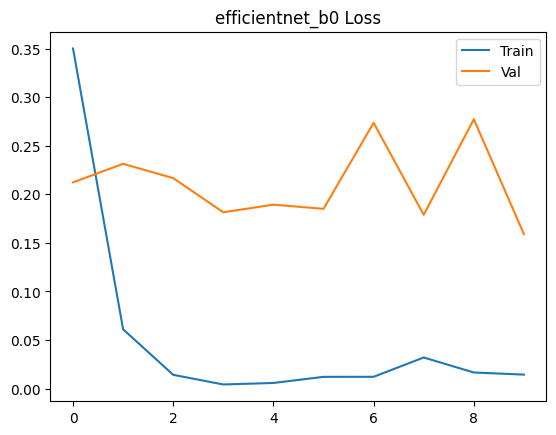

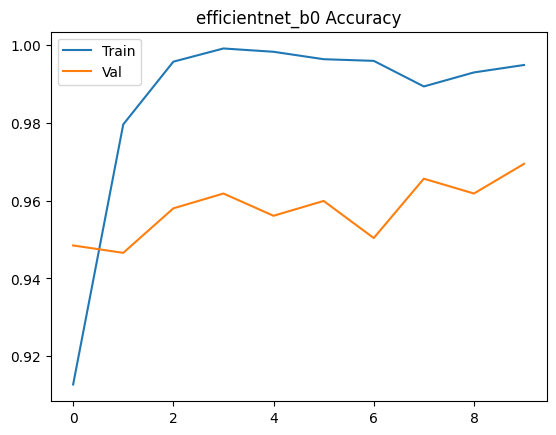

              precision    recall  f1-score   support

      Normal       0.97      0.65      0.78       234
   Pneumonia       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624



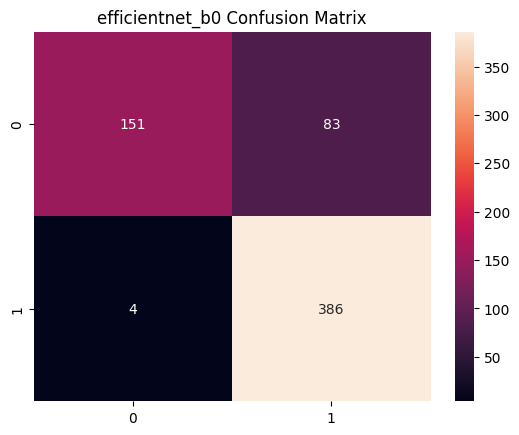

Accuracy: 0.8605769230769231
Precision: 0.879714904738978
Recall: 0.8605769230769231
F1: 0.8528307561551512


In [ ]:
train_model("efficientnet_b0")